#### This notebook plots the strength of the AMOC as a time series.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from collections import OrderedDict

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33111,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:39053,Total threads: 1
Dashboard: /proxy/36925/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:45267,


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
    ('Warming',  {'expt': '1deg_jra55_ryf_warm_x1'}),
    ('Control',  {'expt': '1deg_jra55_ryf_cont'}),
    ('Cooling',  {'expt': '1deg_jra55_ryf_cool_x1'})
])


In [6]:
# pd.set_option('display.max_rows', 300)
# cc.querying.get_variables(session, '1deg_jra55_ryf_cool_x1')

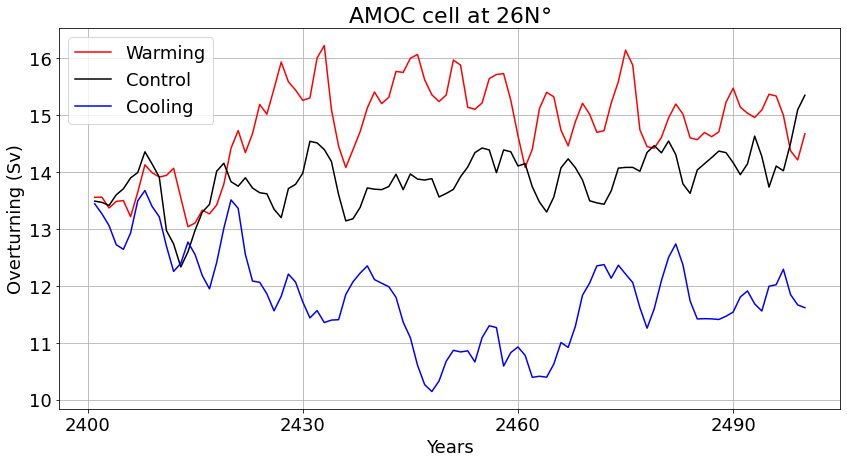

In [9]:
keys = ['Warming', 'Control', 'Cooling']
colors = {'Warming': 'r','Control': 'k','Cooling':'b'}
linestyles = {'Warming': '-','Control': '-','Cooling':'-'}
yr_beg = '2400-01-01'
yr_end = '2499-12-31'

amocs = []

plt.figure(figsize=(14, 7))

for ekey in exptdict:
    expt = exptdict[ekey]['expt']
    
    # Need to do open data manually because something weird was going on...:
    
    var = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean-3d-ty_trans_rho-1-monthly-mean-ym*', combine='by_coords').ty_trans_rho.sel(time=slice(yr_beg, yr_end))
    psi_amoc = var.sel(grid_xt_ocean = slice(- 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean-ym*', combine='by_coords').ty_trans_rho_gm.sel(time=slice(yr_beg, yr_end))
        psi_amoc_gm = var2.sel(grid_xt_ocean = slice( - 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean().dropna('time').load()
    
    amocs.append(psi_amoc_sum)
    
    psi_amoc_sum.plot(label = ekey, color = colors[ekey], linestyle = linestyles[ekey])
        
    
xlims = plt.xlim()
plt.xlabel('Years', fontsize=18)
plt.ylabel('Overturning (Sv)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('AMOC cell at 26N$\degree$', fontsize=22)
plt.grid()
# plt.savefig('AMOC_test.jpg', bbox_inches='tight', dpi=300)

(<xarray.DataArray ()>
 array(2.413088, dtype=float32)
 Coordinates:
     grid_yu_ocean  float64 26.04,
 <xarray.DataArray ()>
 array(-1.1477954, dtype=float32)
 Coordinates:
     grid_yu_ocean  float64 26.04)

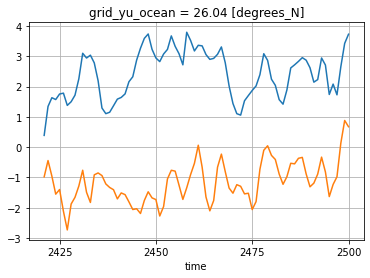

In [27]:
amoc_cool_anom = amocs[1] - amocs[2]
amoc_warm_anom = amocs[1] - amocs[0]

amoc_cool_anom.sel(time=slice('2420-01-01',None)).plot()
amoc_warm_anom.sel(time=slice('2420-01-01',None)).plot()
plt.grid()

amoc_cool_anom.sel(time=slice('2420-01-01',None)).mean(), amoc_warm_anom.sel(time=slice('2420-01-01',None)).mean()